In [1]:
import yfinance as yf
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import os
from fiftyone.utils.ultralytics import torch
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import itertools
import random

2025-06-07 18:11:38.867208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 18:11:38.907681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749312698.928375  738049 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749312698.934957  738049 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 18:11:38.975067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
ticker = "BTC-USD"
data = yf.download(ticker, start="2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))
data = data[["Close"]]
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,BTC-USD
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


class BtcDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
def get_data(seq_length, data):
    log_series = np.log1p(data.values)

    train_size = int(len(log_series) * 0.8)
    train_data = log_series[:train_size]
    val_data = log_series[train_size:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    val_scaled = scaler.transform(val_data.reshape(-1, 1))

    all_scaled = np.vstack([train_scaled, val_scaled])

    X, y = [], []
    for i in range(len(all_scaled) - seq_length):
        X.append(all_scaled[i:i + seq_length])
        y.append(all_scaled[i + seq_length])

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    split_idx = train_size - seq_length
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    train_dataset = BtcDataset(X_train, y_train)
    val_dataset = BtcDataset(X_val, y_val)

    return train_dataset, val_dataset

In [6]:
def get_next_run_index(model_name, base_dir="runs"):
    os.makedirs(base_dir, exist_ok=True)
    existing = [d for d in os.listdir(base_dir) if d.startswith(model_name + "_")]

    indices = []
    for name in existing:
        try:
            idx = int(name.split("_")[-1])
            indices.append(idx)
        except ValueError:
            continue

    next_idx = max(indices, default=0) + 1
    run_name = f"{model_name}_{next_idx:03d}"
    return os.path.join(base_dir, run_name)

In [7]:
def set_and_train(model_name, hidden_size, num_layers, epochs, lr, history_days):
    if model_name == "LSTM":
        model = LSTMModel(1, hidden_size, num_layers).to(device)
    elif model_name == "RNN":
        model = RNNModel(1, hidden_size, num_layers).to(device)
    elif model_name == "GRU":
        model = GRUModel(1, hidden_size, num_layers).to(device)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    train_dataset, val_dataset = get_data(history_days, data)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    os.makedirs('runs', exist_ok=True)
    writer = SummaryWriter(log_dir=get_next_run_index(model_name))

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)

        train_loss /= len(train_dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y.squeeze())
                val_loss += loss.item() * batch_X.size(0)

        val_loss /= len(val_dataset)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)

    writer.close()

    return model, val_dataset

In [8]:
def plot_one_day_prediction(model, val_dataset):
    val_loader = DataLoader(val_dataset, batch_size=64)

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            output = model(batch_X).squeeze().cpu().numpy()
            target = batch_y.squeeze().cpu().numpy()
            predictions.extend(output)
            actuals.extend(target)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label="True price", linewidth=2)
    plt.plot(predictions, label="Predicted price", linestyle='--')
    plt.xlabel("Days")
    plt.ylabel("BTC (USD)")
    plt.title("LSTM")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_738049/2307884873.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32)


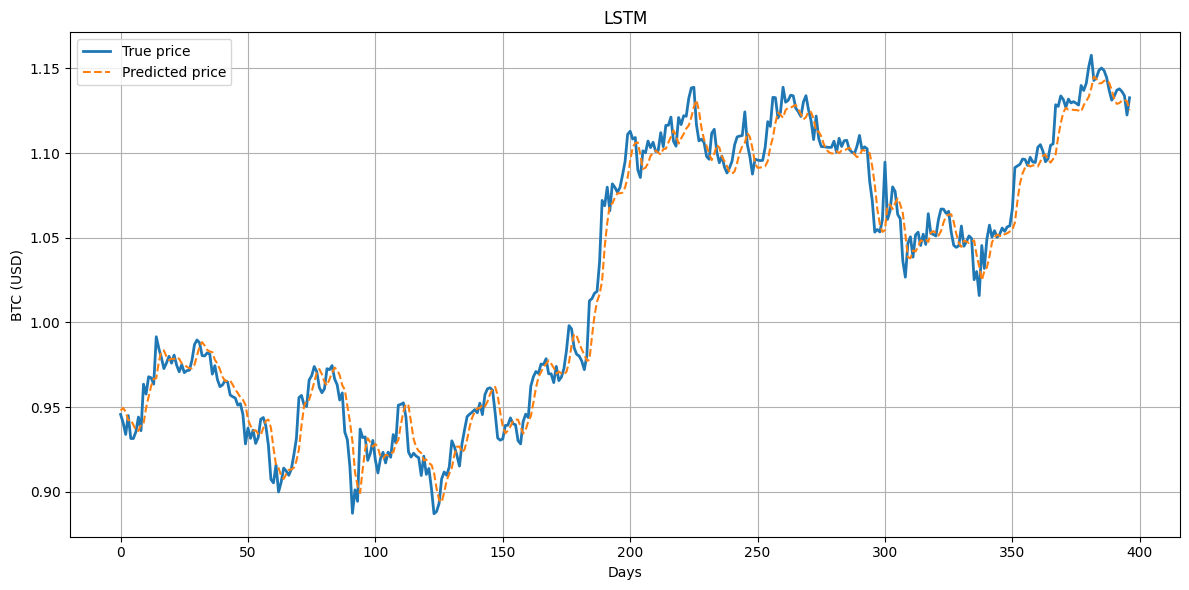

In [9]:
model, val_dataset = set_and_train(model_name="GRU",hidden_size=64,num_layers=2,epochs=30,lr=1e-3,history_days=15)
plot_one_day_prediction(model, val_dataset)

In [10]:
def evaluate_recursive_forecast(model, val_dataset, history_days=30, future_days=30, render=False):
    model.eval()

    full_data = val_dataset.X.squeeze(-1).numpy()
    targets = val_dataset.y.squeeze().numpy()

    full_series = np.concatenate([full_data[0], targets])

    start = len(full_series) - (history_days + future_days)

    history_seq = full_series[start:start + history_days]
    true_future = full_series[start + history_days:start + history_days + future_days]

    sequence = torch.tensor(history_seq.reshape(1, history_days, 1), dtype=torch.float32).to(device)
    predictions = []

    with torch.no_grad():
        for _ in range(future_days):
            next_val = model(sequence)
            predictions.append(next_val.item())

            next_input = next_val.view(1, 1, 1)
            sequence = torch.cat((sequence[:, 1:, :], next_input), dim=1)

    score = mean_squared_error(true_future, predictions)

    if render:
        full_x = list(range(history_days + future_days))
        pred_x = list(range(history_days, history_days + future_days))

        plt.figure(figsize=(14, 6))
        plt.plot(full_x, np.concatenate([history_seq, true_future]), label="True Sequence", color='blue', linewidth=2)
        plt.plot(pred_x, predictions, label="Predicted", color='orange', linestyle='--', linewidth=2)
        plt.title(f"Forecast ({history_days}d history -> {future_days}d future)\nMSE: {score:.6f}")
        plt.xlabel("Time Step")
        plt.ylabel("Scaled Log Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return score, predictions, true_future

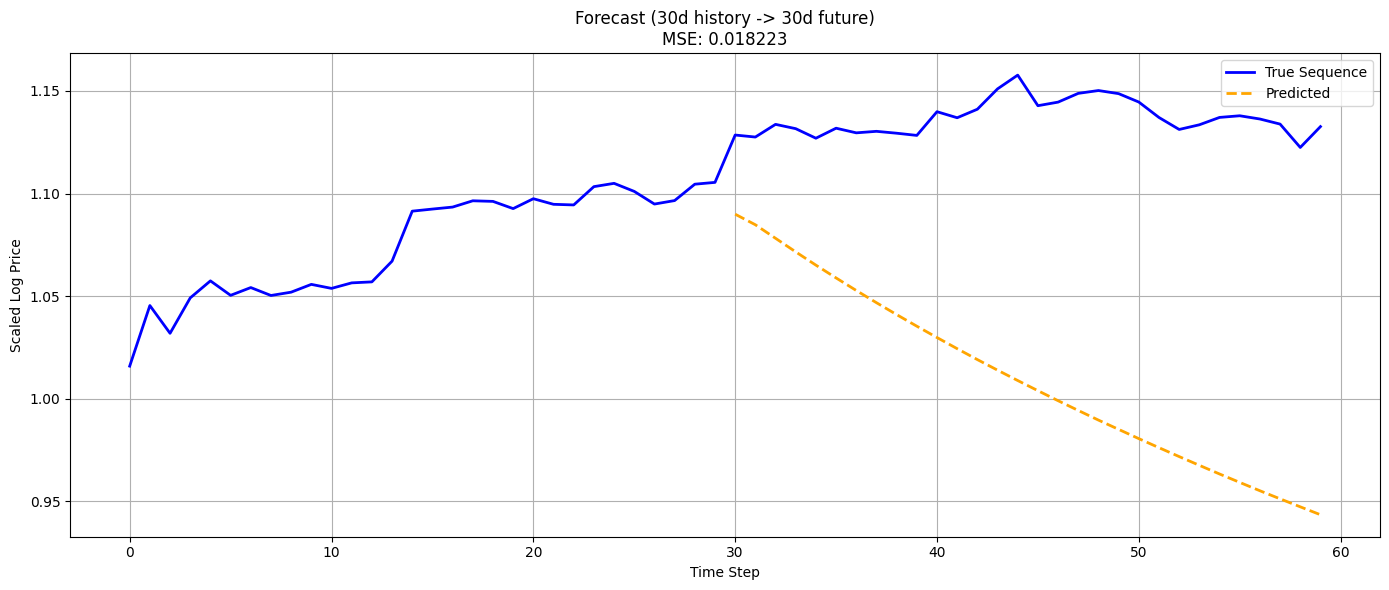

In [11]:
model, val_dataset = set_and_train(
    model_name="GRU",
    hidden_size=64,
    num_layers=2,
    epochs=30,
    lr=1e-3,
    history_days=30,
)

score, preds, true_vals = evaluate_recursive_forecast(
    model=model,
    val_dataset=val_dataset,
    history_days=30,
    future_days=30,
    render=True
)



In [14]:
def run_grid_search():
    model_types = ["LSTM", "GRU", "RNN"]
    hidden_sizes = [32, 64, 128]
    num_layers_list = [1, 2]
    lrs = [1e-2, 1e-3, 1e-4]
    epochs = [20]
    history_days = [10, 15, 30, 60]
    future_days = 30

    param_grid = list(itertools.product(
        model_types, hidden_sizes, num_layers_list, lrs, epochs, history_days
    ))

    total_configs = len(param_grid)
    best_score = float("inf")
    best_config = None
    best_model = None
    best_val_dataset = None

    for idx, (model_name, hidden_size, num_layers, lr, ep, hist_days) in enumerate(param_grid):
        print(f"\n[{idx + 1}/{total_configs}] Training {model_name} | Hidden: {hidden_size}, Layers: {num_layers}, LR: {lr}, Epochs: {ep}, History: {hist_days}")

        model, val_dataset = set_and_train(
            model_name=model_name,
            hidden_size=hidden_size,
            num_layers=num_layers,
            epochs=ep,
            lr=lr,
            history_days=hist_days,
        )

        score, _, _ = evaluate_recursive_forecast(
            model=model,
            val_dataset=val_dataset,
            history_days=hist_days,
            future_days=future_days,
            render=False
        )

        print(f"Score (MSE): {score:.6f}")

        if score < best_score:
            best_score = score
            best_config = {
                "model": model_name,
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "lr": lr,
                "epochs": ep,
                "history_days": hist_days,
            }
            best_model = model
            best_val_dataset = val_dataset

    return best_model, best_config, best_val_dataset, best_score


[1/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.01, Epochs: 20, History: 10
Score (MSE): 0.007242

[2/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.01, Epochs: 20, History: 15
Score (MSE): 0.007354

[3/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.01, Epochs: 20, History: 30
Score (MSE): 0.003321

[4/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.01, Epochs: 20, History: 60
Score (MSE): 0.007882

[5/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.001, Epochs: 20, History: 10
Score (MSE): 0.029913

[6/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.001, Epochs: 20, History: 15
Score (MSE): 0.015830

[7/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.001, Epochs: 20, History: 30
Score (MSE): 0.023565

[8/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.001, Epochs: 20, History: 60
Score (MSE): 0.030641

[9/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.0001, Epochs: 20, History: 10
Score (MSE): 0.158766

[10/216] Training LSTM | Hidden: 32, Layers: 1, LR: 0.000

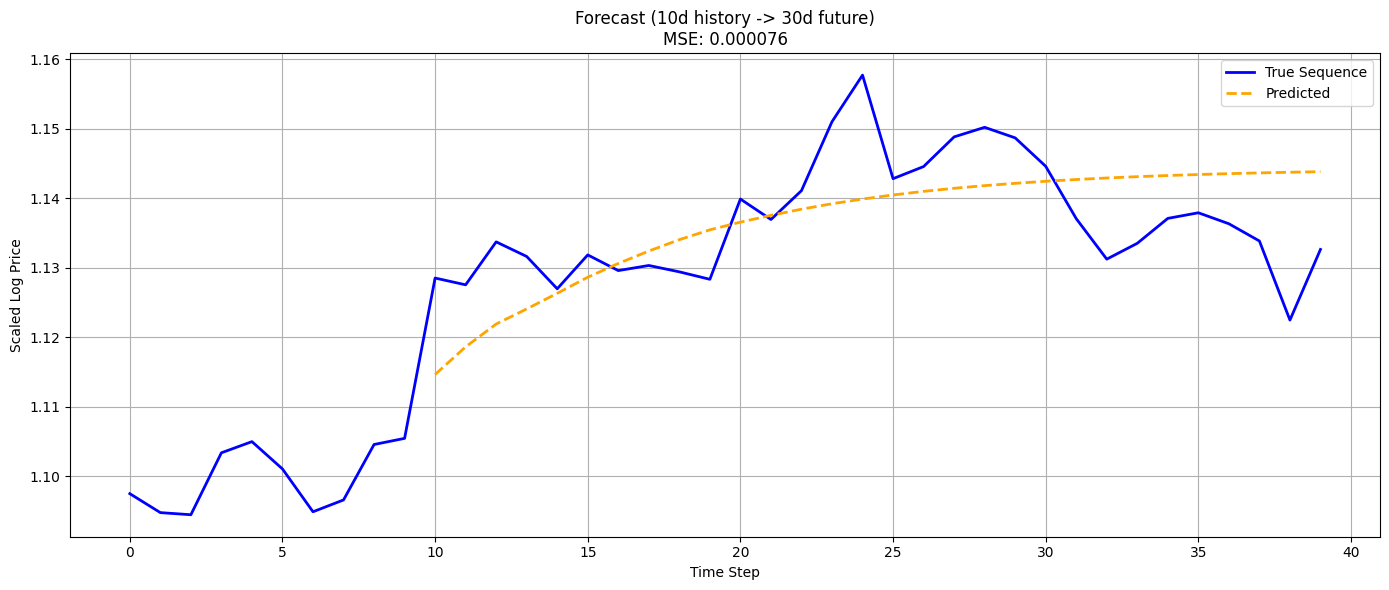


Best Configuration:
{'model': 'RNN', 'hidden_size': 128, 'num_layers': 1, 'lr': 0.01, 'epochs': 20, 'history_days': 10}


In [15]:
best_model, best_config, best_val_dataset, best_score = run_grid_search()

evaluate_recursive_forecast(best_model, best_val_dataset, history_days=best_config["history_days"], future_days=30, render=True)

print("\nBest Configuration:")
print(best_config)

## Summary

1) Poor performance comes from lack of data and volatility, which is difficult to mitigate due to random nature of price formation (unless you know EVERYTHING that impacts the BTC)

2) It is intuitive the model tends to focus on latest few days to make predictions. Our results of parameter-tuning support this assumption.

3) "Recursive prediction" approach leads to error accumulation that is unstable without correction. So is to say, after ~5 iterations model's output may become totally irrelevant

4) The volatility issues is partially addressed by applying log-transformation and scaler fitting on train-set only. (Here might be a quantitative finance article about exponential price growth...)

5) It appears that RNN outperforms LSTM and GRN on parameter grid I've managed to iterate through. I suppose that for this task advanced gating is excessive.